## Load Experiment Data

In [1]:
# Load the policy
import os
import pandas
from garage.experiment import Snapshotter
import pandas as pd
EXPERIMENT_NAME = "CL_point_env_34" #13
experiment_dir = os.path.join("data/local/experiment", EXPERIMENT_NAME)
snapshotter = Snapshotter()
data = snapshotter.load(experiment_dir)
policy = data['algo'].policy
experiment_data_path = os.path.join(experiment_dir, "experiment.json")
experiment_data = pandas.read_json(experiment_data_path)

# You can also access other components of the experiment
env = data['env']

progress_csv_path = os.path.join(experiment_dir, 'progress.csv')
# progress_df = pd.read_csv(progress_csv_path)

2025-01-10 10:44:46.206544: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.




Failed to import TF-Keras. Please note that TF-Keras is not installed by default when you install TensorFlow Probability. This is so that JAX-only users do not have to install TensorFlow or TF-Keras. To use TensorFlow Probability with TensorFlow, please install the tf-keras or tf-keras-nightly package.
This can be be done through installing the tensorflow-probability[tf] extra.




Failed to import TF-Keras. Please note that TF-Keras is not installed by default when you install TensorFlow Probability. This is so that JAX-only users do not have to install TensorFlow or TF-Keras. To use TensorFlow Probability with TensorFlow, please install the tf-keras or tf-keras-nightly package.
This can be be done through installing the tensorflow-probability[tf] extra.




/Users/paulnitschke/Desktop/projects/geo_meta_rl/garage/experiment/deterministic.py:36: UserWarning: Enabeling deterministic mode in PyTorch can have a performance impact when using GPU.
  warnings.warn(


In [2]:
num_train_tasks=4
from garage.experiment.task_sampler import SetTaskSampler
from garage.envs import GymEnv, normalize
from garage.envs.point_env import PointEnv
from garage.torch.algos.CLMeta import PEARLWorker

worker_args = dict(deterministic=True, accum_context=True)
env_sampler = SetTaskSampler(
    PointEnv,
    wrapper=lambda env, _: normalize(
        env))
env = env_sampler.sample(num_train_tasks)

In [3]:
from garage.experiment.meta_evaluator import MetaEvaluator

meta_evaluator = MetaEvaluator(test_tasks=env,
                               worker_class=PEARLWorker,
                               worker_args=worker_args,
                               n_exploration_eps=10,
                               n_test_tasks=2,
                               return_task_embeddings=True,
                               log_wandb=False)

trajs, task_embeddings = meta_evaluator.evaluate(algo=data['algo'])



Failed to import TF-Keras. Please note that TF-Keras is not installed by default when you install TensorFlow Probability. This is so that JAX-only users do not have to install TensorFlow or TF-Keras. To use TensorFlow Probability with TensorFlow, please install the tf-keras or tf-keras-nightly package.
This can be be done through installing the tensorflow-probability[tf] extra.




/Users/paulnitschke/Desktop/projects/geo_meta_rl/garage/experiment/meta_evaluator.py:96: LoggerWarning: No outputs have been added to the logger.
  logger.log('Sampling for adapation and meta-testing...')
/Users/paulnitschke/Desktop/projects/geo_meta_rl/garage/experiment/meta_evaluator.py:96: LoggerWarning: Log data of type str was not accepted by any output
  logger.log('Sampling for adapation and meta-testing...')
/Users/paulnitschke/Desktop/projects/geo_meta_rl/garage/experiment/deterministic.py:36: UserWarning: Enabeling deterministic mode in PyTorch can have a performance impact when using GPU.
  warnings.warn(
/Users/paulnitschke/miniconda3/envs/env_geo_meta_rl/lib/python3.9/site-packages/torch/distributions/distribution.py:53: UserWarning: <class 'garage.torch.distributions.tanh_normal.TanhNormal'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(
/Users/paulnits

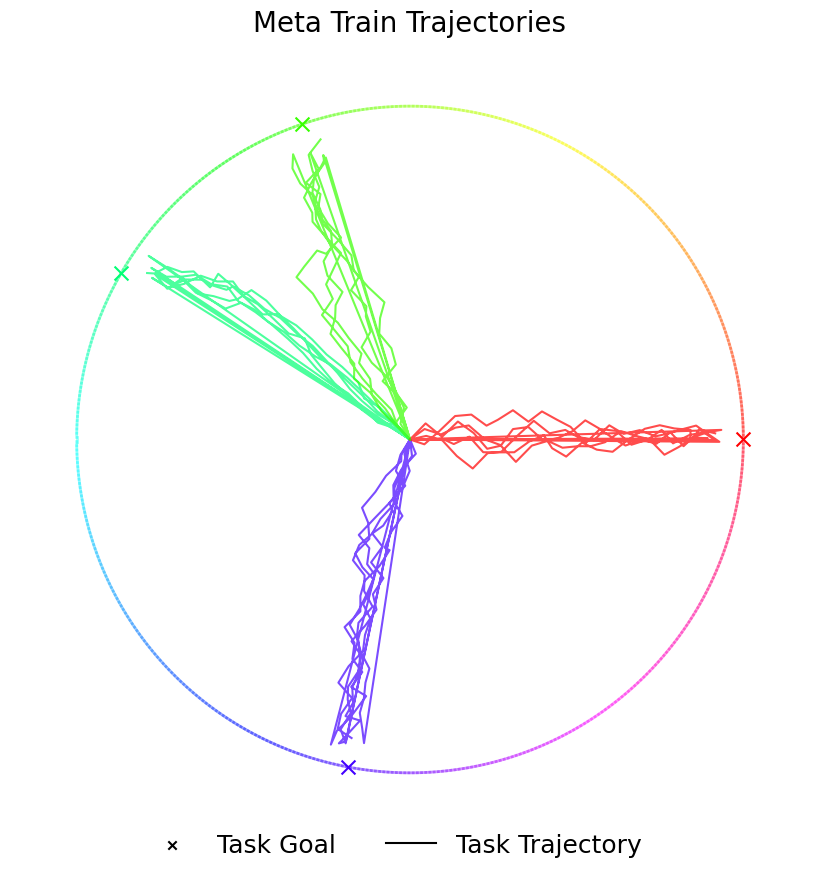

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

def plot_trajs_on_circle(trajs, marker_trajs, title):
    # Create a colormap and normalizer
    cmap = plt.cm.hsv  # Use the hsv colormap
    norm = Normalize(vmin=0, vmax=2 * np.pi)

    # Generate points for the circle
    angles = np.linspace(0, 2 * np.pi, 500)
    x_circle = 2 * np.cos(angles)
    y_circle = 2 * np.sin(angles)

    # Create the figure and axis
    fig = plt.figure(figsize=(12, 12))  # Increase figure size for wider space around the circle
    ax = fig.add_subplot(111)

    # Set the fixed size for the circle area (8x8 inches)
    circle_size_inches = 8
    fig_width, fig_height = fig.get_size_inches()

    # Calculate the position for the circle to take up exactly 8x8 inches
    left_margin = (fig_width - circle_size_inches) / 2 / fig_width
    bottom_margin = (fig_height - circle_size_inches) / 2 / fig_height
    ax_width = circle_size_inches / fig_width
    ax_height = circle_size_inches / fig_height

    ax.set_position([left_margin, bottom_margin, ax_width, ax_height])  # Adjust axis position

    # Set fixed aspect ratio and limits
    ax.set_aspect('equal', adjustable='box')
    circle_radius = 2
    ax.set_xlim(-circle_radius * 1.2, circle_radius * 1.2)  # Add more padding around the circle
    ax.set_ylim(-circle_radius * 1.2, circle_radius * 1.2)  # Add more padding around the circle

    # Add grid in the background
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

    # Plot the circle with continuous color
    for i in range(len(angles) - 1):
        ax.plot(x_circle[i:i + 2], y_circle[i:i + 2], color=cmap(norm(angles[i])), linewidth=2, alpha=0.4)

    # Plot trajectories
    for task_traj in trajs:
        goal_x, goal_y = task_traj.env_infos["task"][0]["goal"]
        goal_angle = (np.arctan2(goal_y, goal_x) + 2 * np.pi) % (2 * np.pi)

        goal_color = cmap(norm(goal_angle))
        ax.plot(task_traj.observations[:, 0], task_traj.observations[:, 1], c=goal_color, alpha=0.7)

    # Plot markers for task goals
    for marker_traj in marker_trajs:
        goal_x, goal_y = marker_traj.env_infos["task"][0]["goal"]
        goal_angle = (np.arctan2(goal_y, goal_x) + 2 * np.pi) % (2 * np.pi)

        goal_color = cmap(norm(goal_angle))
        ax.scatter(goal_x, goal_y, color=goal_color, marker='x', s=100)

    ax.scatter([], [], color='black', marker='x', label='Task Goal')
    ax.plot([], [], color='black', label='Task Trajectory')

    # Turn off the axis
    ax.axis('off')

    # Add title
    plt.title(title, fontsize=20)
    ax.legend(ncol=2, loc='lower center', bbox_to_anchor=(0.48, -0.05), frameon=False, fontsize=18)
    # Save the plot
    plt.show()



plot_trajs_on_circle(trajs, trajs, "Meta Train Trajectories")

# Generalization Performance

In [120]:
num_test_tasks=200

worker_args = dict(deterministic=True, accum_context=True)
env_sampler = SetTaskSampler(
    PointEnv,
    wrapper=lambda env, _: normalize(
        env),
        sample_mode="linspace")
test_envs = env_sampler.sample(num_test_tasks)

meta_evaluator = MetaEvaluator(test_tasks=test_envs,
                               worker_class=PEARLWorker,
                               worker_args=worker_args,
                               n_exploration_eps=10,
                               n_test_tasks=num_test_tasks,
                               return_task_embeddings=True,
                               log_wandb=False)

test_trajs, test_task_embeddings = meta_evaluator.evaluate(algo=data['algo'])



Failed to import TF-Keras. Please note that TF-Keras is not installed by default when you install TensorFlow Probability. This is so that JAX-only users do not have to install TensorFlow or TF-Keras. To use TensorFlow Probability with TensorFlow, please install the tf-keras or tf-keras-nightly package.
This can be be done through installing the tensorflow-probability[tf] extra.




/Users/paulnitschke/Desktop/projects/geo_meta_rl/garage/experiment/deterministic.py:36: UserWarning: Enabeling deterministic mode in PyTorch can have a performance impact when using GPU.
  warnings.warn(
/Users/paulnitschke/miniconda3/envs/env_geo_meta_rl/lib/python3.9/site-packages/torch/distributions/distribution.py:53: UserWarning: <class 'garage.torch.distributions.tanh_normal.TanhNormal'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


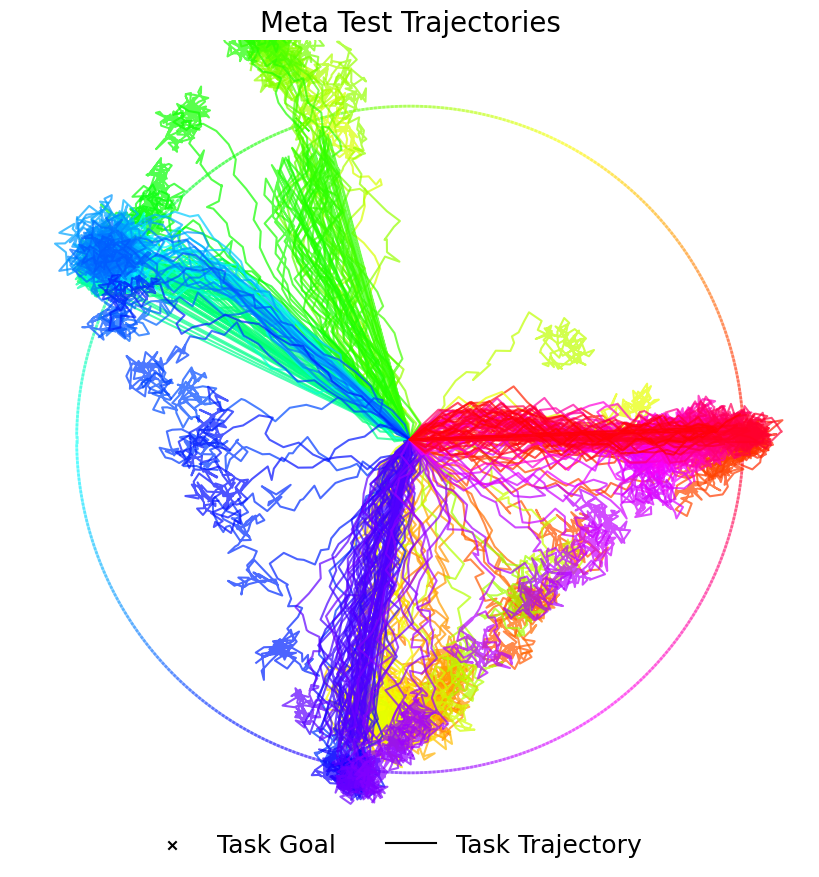

In [121]:
plot_trajs_on_circle(test_trajs, trajs, "Meta Test Trajectories")

# How well do test-tasks do with correct, hard-coded embedding?

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

def plot_trajs_and_embeddings_on_circle(marker_trajs,
                                        trajs_embeddings, 
                                        task_embeddings,
                                        title):

    # Create a colormap and normalizer
    cmap = plt.cm.hsv  # Use the hsv colormap
    norm = Normalize(vmin=0, vmax=2 * np.pi)

    # Generate points for the circle
    angles = np.linspace(0, 2 * np.pi, 500)
    x_circle = 2 * np.cos(angles)
    y_circle = 2 * np.sin(angles)

    # Create the plot
    fig, ax = plt.subplots()
    ax.set_aspect('equal', adjustable='datalim')

    # Add grid in the background
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

    # Plot the circle with continuous color
    for i in range(len(angles) - 1):
        ax.plot(x_circle[i:i + 2], y_circle[i:i + 2], color=cmap(norm(angles[i])), linewidth=2, alpha=0.4)


    # Plot markers for task goals
    for marker_traj in marker_trajs:
        goal_x, goal_y = marker_traj.env_infos["task"][0]["goal"]
        goal_angle = (np.arctan2(goal_y, goal_x) + 2 * np.pi) % (2 * np.pi)

        goal_color = cmap(norm(goal_angle))
        ax.scatter(goal_x, goal_y, color=goal_color, marker='x', s=100)

    for idx, traj_embedding in enumerate(trajs_embeddings):
        goal_x, goal_y = traj_embedding.env_infos["task"][0]["goal"]
        goal_angle = (np.arctan2(goal_y, goal_x) + 2 * np.pi) % (2 * np.pi)
        goal_color = cmap(norm(goal_angle))
        plt.quiver(
                0, 0, task_embeddings[idx][0][0], task_embeddings[idx][0][1], angles='xy', scale_units='xy', scale=0.5,
                color=goal_color)
            

    ax.axis('off')
    ax.scatter([], [], color='black', marker='x', label='Train Task Goal')
    ax.plot([], [], color='black', label='Task Embedding')
    ax.tick_params(axis='both', which='major', labelsize=0) 
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.1) 
    ax.legend(ncol=2, loc='lower center', bbox_to_anchor=(0.48, -0.12), frameon=False, fontsize=18)
    fig.set_size_inches(8, 8)
    plt.title(title, fontsize=20)
    plt.show()

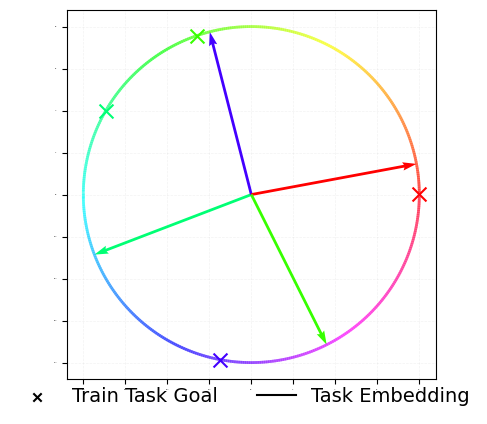

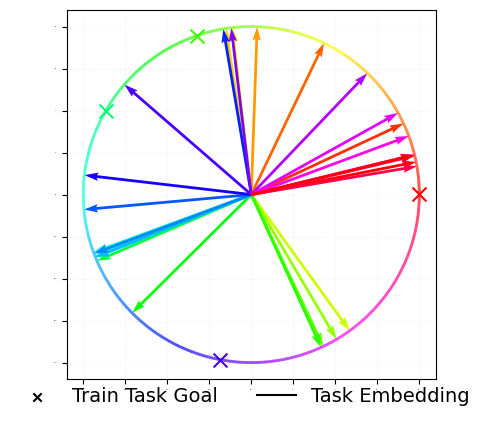

In [65]:
plot_trajs_and_embeddings_on_circle(marker_trajs=trajs, 
                                    trajs_embeddings=trajs,
                                    task_embeddings=task_embeddings
                                    )
plot_trajs_and_embeddings_on_circle(marker_trajs=trajs, 
                                    trajs_embeddings=test_trajs,
                                    task_embeddings=test_task_embeddings
                                    )

## Normalize orientation and rotation of embeddings

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

def rotate_point(p, angle):
    """
    Rotates a point on the unit circle by a given angle.

    Parameters:
    - p: numpy array of shape (2,), coordinates of the point on the unit circle.
    - angle: float, the angle in radians to rotate the point.

    Returns:
    - rotated_p: numpy array of shape (2,), the rotated point coordinates.
    """
    # Rotation matrix
    rotation_matrix = np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle), np.cos(angle)]
    ])

    # Apply the rotation matrix
    rotated_p = np.dot(rotation_matrix, p)

    return rotated_p

def plot_trajs_and_embeddings_on_circle_normalized(marker_trajs, trajs_embeddings, 
                                                   task_embeddings,
                                                   title,
                                                   reverse_embedding_colors=True,
                                                   rotation_angle=0
                                                   ):
    # Create a colormap and normalizer
    cmap = plt.cm.hsv  # Use the hsv colormap
    norm = Normalize(vmin=0, vmax=2 * np.pi)

    # Generate points for the circle
    angles = np.linspace(0, 2 * np.pi, 500)
    x_circle = 2 * np.cos(angles)
    y_circle = 2 * np.sin(angles)

    # Create the figure and axis
    fig = plt.figure(figsize=(12, 12))  # Increase figure size for wider space around the circle
    ax = fig.add_subplot(111)

    # Set the fixed size for the circle area (8x8 inches)
    circle_size_inches = 8
    fig_width, fig_height = fig.get_size_inches()

    # Calculate the position for the circle to take up exactly 8x8 inches
    left_margin = (fig_width - circle_size_inches) / 2 / fig_width
    bottom_margin = (fig_height - circle_size_inches) / 2 / fig_height
    ax_width = circle_size_inches / fig_width
    ax_height = circle_size_inches / fig_height

    ax.set_position([left_margin, bottom_margin, ax_width, ax_height])  # Adjust axis position

    # Set fixed aspect ratio and limits
    ax.set_aspect('equal', adjustable='box')
    circle_radius = 2
    ax.set_xlim(-circle_radius * 1.2, circle_radius * 1.2)  # Add more padding around the circle
    ax.set_ylim(-circle_radius * 1.2, circle_radius * 1.2)  # Add more padding around the circle

    # Add grid in the background
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

    # Plot the circle with continuous color
    for i in range(len(angles) - 1):
        ax.plot(x_circle[i:i + 2], y_circle[i:i + 2], color=cmap(norm(angles[i])), linewidth=2, alpha=0.4)

    # Plot markers for task goals
    goal_colors_markers = []
    for marker_traj in marker_trajs:
        goal_x, goal_y = marker_traj.env_infos["task"][0]["goal"]
        goal_angle = (np.arctan2(goal_y, goal_x) + 2 * np.pi) % (2 * np.pi)

        goal_color = cmap(norm(goal_angle))
        ax.scatter(goal_x, goal_y, color=goal_color, marker='x', s=100)
        goal_colors_markers.append(goal_color)

    goal_colors_embeddings = []
    for idx, traj_embedding in enumerate(trajs_embeddings):
        goal_x, goal_y = traj_embedding.env_infos["task"][0]["goal"]
        goal_angle = (np.arctan2(goal_y, goal_x) + 2 * np.pi) % (2 * np.pi)
        goal_color = cmap(norm(goal_angle))
        goal_colors_embeddings.append(goal_color)

    if reverse_embedding_colors:
        goal_colors_embeddings = goal_colors_embeddings[::-1]
    for idx, task_embedding in enumerate(task_embeddings):
        if rotation_angle != 0:
            task_embedding = rotate_point(task_embedding[0], rotation_angle)
            task_embedding=[task_embedding]
        plt.quiver(
                0, 0, task_embedding[0][0], task_embedding[0][1], angles='xy', scale_units='xy', scale=0.5,
                color=goal_colors_embeddings[idx])

    ax.scatter([], [], color='black', marker='x', label='Task Goal')
    ax.plot([], [], color='black', label='Task Embedding')

    # Turn off the axis
    ax.axis('off')

    # Add title
    plt.title(title, fontsize=20)
    ax.legend(ncol=2, loc='lower center', bbox_to_anchor=(0.48, -0.05), frameon=False, fontsize=18)
    # Save the plot
    plt.show()

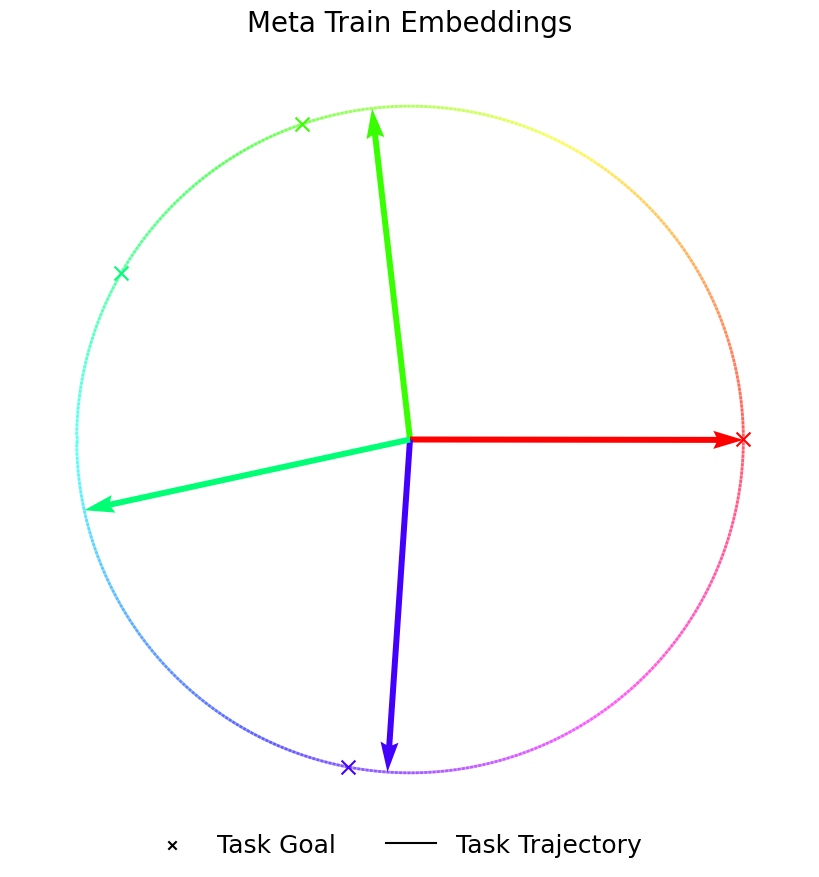

In [116]:
# plot_trajs_and_embeddings_on_circle_normalized(marker_trajs=trajs, 
#                                     trajs_embeddings=trajs,
#                                     task_embeddings=task_embeddings,
#                                     reverse_embedding_colors=False,
#                                     rotation_angle=0
#                                     )

# plot_trajs_and_embeddings_on_circle_normalized(marker_trajs=trajs, 
#                                     trajs_embeddings=trajs,
#                                     task_embeddings=task_embeddings,
#                                     reverse_embedding_colors=True,
#                                     rotation_angle=0
#                                     )

plot_trajs_and_embeddings_on_circle_normalized(marker_trajs=trajs, 
                                    trajs_embeddings=trajs,
                                    task_embeddings=task_embeddings,
                                    title="Meta Train Embeddings",
                                    reverse_embedding_colors=True,
                                    rotation_angle=np.pi/2+0.92*np.pi
                                    )

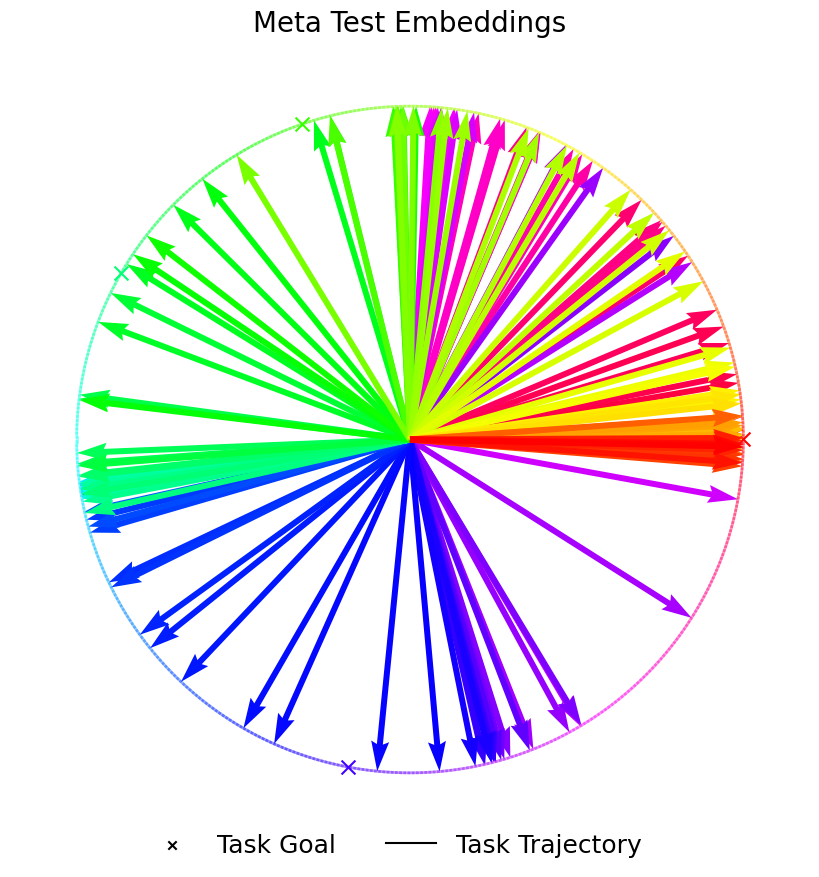

In [122]:
plot_trajs_and_embeddings_on_circle_normalized(marker_trajs=trajs, 
                                    trajs_embeddings=test_trajs,
                                    task_embeddings=test_task_embeddings,
                                    title="Meta Test Embeddings",
                                    reverse_embedding_colors=True,
                                    rotation_angle=1.93*np.pi
                                    )

In [8]:
import numpy as np

import numpy as np

def compute_angle(p1, p2):
    """
    Computes the angle in radians to rotate point p1 to point p2 on the unit circle.

    Parameters:
    - p1: numpy array of shape (2,), coordinates of the first point on the unit circle.
    - p2: numpy array of shape (2,), coordinates of the second point on the unit circle.

    Returns:
    - angle: float, the signed angle in radians.
    """
    # Compute dot product and determinant
    dot = np.dot(p1, p2)
    det = np.linalg.det(np.array([p1, p2]))

    # Calculate the angle using arctan2
    angle = np.arctan2(det, dot)

    return angle

def rotate_point(p, angle):
    """
    Rotates a point on the unit circle by a given angle.

    Parameters:
    - p: numpy array of shape (2,), coordinates of the point on the unit circle.
    - angle: float, the angle in radians to rotate the point.

    Returns:
    - rotated_p: numpy array of shape (2,), the rotated point coordinates.
    """
    # Rotation matrix
    rotation_matrix = np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle), np.cos(angle)]
    ])

    # Apply the rotation matrix
    rotated_p = np.dot(rotation_matrix, p)

    return rotated_p



# Example usage
p1 = (1,0)
p2 = (train_task_1_embedding[0], train_task_1_embedding[1])

# Compute the angle to rotate p1 to p2
angle = compute_angle(p1, p2)
print(f"The angle to rotate {p1} to {p2} is {angle} radians.")

# Rotate p1 by the computed angle
rotated_p1 = rotate_point(p1, angle)
print(f"Rotating {p1} by {angle} radians gives {rotated_p1}.")

The angle to rotate (1, 0) to (-0.76634437, -0.64243007) is -2.4439276346218755 radians.
Rotating (1, 0) by -2.4439276346218755 radians gives [-0.76634434 -0.64243004].


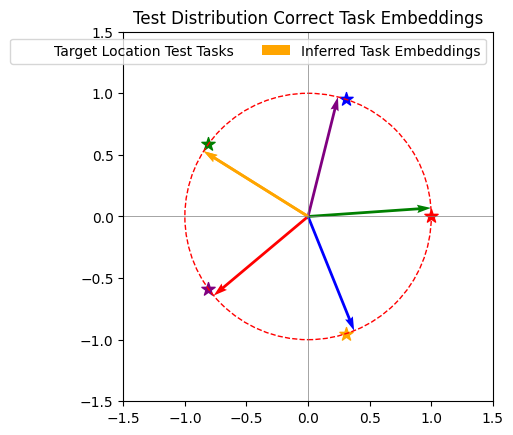

In [27]:
inferred_embeddings=[]
test_goal_positions = [test_envs[i]._make_env().reset()[1] for i in range(num_test_tasks)]

colors = ['red', 'blue', 'green', 'purple', 'orange']
for idx_test_goal_position, test_goal_position in enumerate(test_goal_positions):
    test_goal_position["goal"] = test_goal_position["goal"] / np.linalg.norm(test_goal_position["goal"])
    inferred_embedding = rotate_point(test_goal_position["goal"], angle)
    inferred_embeddings.append(inferred_embedding)
    plt.scatter(test_goal_position["goal"][0], test_goal_position["goal"][1], marker='*', s=100, color=colors[idx_test_goal_position])
    plt.quiver(0, 0, inferred_embedding[0], inferred_embedding[1], angles='xy', scale_units='xy', scale=1, color=colors[idx_test_goal_position])

plt.scatter(test_goal_position["goal"][0], test_goal_position["goal"][1], marker='*', s=0, label="Target Location Test Tasks")
plt.quiver(0, 0, inferred_embedding[0], inferred_embedding[1], angles='xy', scale_units='xy', scale=1, color=colors[idx_test_goal_position], label="Inferred Task Embeddings")


unit_circle = plt.Circle((0, 0), 1, color='r', fill=False, linestyle='--')
plt.gca().add_artist(unit_circle)

# Set the aspect of the plot to be equal
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.axhline(0, color='grey', linewidth=0.5)
plt.axvline(0, color='grey', linewidth=0.5)
plt.legend(ncols=2, loc="best")
plt.title("Test Distribution Correct Task Embeddings")
plt.show()

In [28]:
from garage.experiment.meta_evaluator import MetaEvaluator
import torch

# BEGIN: Convert numpy arrays to pytorch tensors
inferred_embeddings = [torch.tensor(embedding) for embedding in inferred_embeddings]
# END:

meta_evaluator = MetaEvaluator(test_tasks=test_envs,
                               worker_class=PEARLWorker,
                               worker_args=worker_args,
                               n_exploration_eps=10,
                               n_test_tasks=5,
                               return_task_embeddings=True,
                               log_wandb=False,
                               hard_coded_embeddings=inferred_embeddings)

hard_coded_embedding_trajs, check_embeddings = meta_evaluator.evaluate(algo=data['algo'])



Failed to import TF-Keras. Please note that TF-Keras is not installed by default when you install TensorFlow Probability. This is so that JAX-only users do not have to install TensorFlow or TF-Keras. To use TensorFlow Probability with TensorFlow, please install the tf-keras or tf-keras-nightly package.
This can be be done through installing the tensorflow-probability[tf] extra.




Text(0.5, 1.0, 'Trajectories of Task 1 and Task 2')

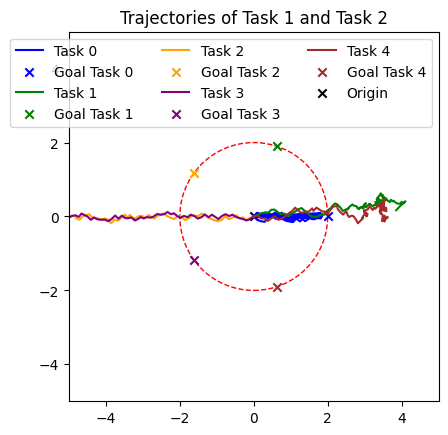

In [29]:
import matplotlib.pyplot as plt
plt.gca().set_aspect('equal', adjustable='box')
circle = plt.Circle((0, 0), 2, color='r', fill=False, linestyle='--')
plt.gca().add_artist(circle)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
colors = ['blue', 'green', 'orange', 'purple', 'brown']
for idx_task, task_traj in enumerate(hard_coded_embedding_trajs):
    plt.plot(task_traj.observations[:,0], task_traj.observations[:,1], label=f"Task {idx_task}", color=colors[idx_task])
    plt.scatter(task_traj.env_infos["task"][0]["goal"][0], task_traj.env_infos["task"][0]["goal"][1], color=colors[idx_task], marker='x', label=f'Goal Task {idx_task}')
plt.scatter(0, 0, color='black', marker='x', label='Origin')
plt.legend(ncol=3)
plt.title("Trajectories of Task 1 and Task 2")